# AOMA vs FEM

In [176]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import signal
import dataloader_halogaland.dataloader as dl
from dataloader_halogaland.plot import plotModeShape
import os
from strid.utils import modal_assurance_criterion

### Load results from AOMA

In [177]:
AOMA_loader = dl.HDF5_result_loader(path=os.getcwd()+'/../Referencebased_Cov-SSI/results/output_5_AOMA.h5')

In [178]:
all_modes = AOMA_loader.get_modes_all_periods()
temps, mean_wind_speed, max_wind_speed, mean_wind_direction, execution_time = AOMA_loader.get_statistics()

In [179]:
print(len(all_modes))

1168


In [180]:
for i in range(len(all_modes)):
    print(all_modes[i][0].frequency)


0.05470429513407341
0.054327306686486915
0.05398642116972002
0.054494285756932256
0.054603303724466715
0.05430512017384485
0.05453120023026052
0.11968517669897448
0.054560132870118565
0.054417591791490756
0.05416645224396545
0.054435790294429284
0.05460252592690805
0.05427675373798346
0.05506894918377888
0.05416368650803476
0.05472572751350821
0.05489533518243689
0.054355109010221676
0.05439518763034021
0.05498310640275766
0.0541529970075224
0.05463765145018718
0.05464630514273568
0.054897729814557546
0.05408802816539203
0.054821147457291435
0.05455399971080308
0.05455205484274155
0.0547996791719834
0.054312608326818425
0.054685993298815704
0.05460729053714653
0.05467551874248368
0.05437324333310013
0.11824561848704107
0.054554623081519704
0.05485033986031345
0.05440713762933199
0.05464775527353662
0.05419568797095255
0.05449759850882179
0.05446065975700527
0.05432032461021565
0.054398133886104524
0.05451610630249293
0.054991366257423006
0.05417043209665093
0.05453706397956109
0.054851

### Load results from FEM model

In [181]:
FEM_loader = dl.FEM_result_loader(path=os.getcwd()+ '/../../../FEM/HalogalandModel_exportmodal.h5')

FEM_modes = FEM_loader.get_all_modes()
f= FEM_loader.f
phis_FEM = FEM_loader.phi
print(type(FEM_modes))

<class 'list'>


### Create mode-trace class

In [257]:
class ModeTrace:
    def __init__(self, reference_modes: list[dl.Mode], length,
                 simcrit = {'freq': 0.05, 'mac': 0.2}):

        self.reference_modes = {}
        for i, mode in enumerate(reference_modes):
            new_mode = {i:mode}
            self.reference_modes.update(new_mode)

        self.mode_trace =  np.empty(shape=[len(self.reference_modes),length], dtype=object)
        self.simcrit = simcrit

    def add_modes_from_period(self, candidate_modes: list[dl.Mode], period: int):
        candidate_modes = candidate_modes
        f_tol = self.simcrit['freq']
        mac_tol = self.simcrit['mac']

        for key, ref_mode in self.reference_modes.items():
            #print('Key = '+ str(key))
            #print(ref_mode.frequency)
            for candidate in candidate_modes:
                delta_f = np.abs(ref_mode.frequency - candidate.frequency)/\
                                    np.max([ref_mode.frequency, candidate.frequency])
                mac_1 = 1 - modal_assurance_criterion(ref_mode.mode_shape, candidate.mode_shape)
                #print(delta_f)
                #print(mac_1)
                if delta_f < f_tol and mac_1 < mac_tol:
                    #print('hei')
                    if not isinstance(self.mode_trace[key, period], dl.Mode):
                        #candidate.delta_f = delta_f
                        #candidate.mac_1 = mac_1
                        self.mode_trace[key, period] = candidate
                        candidate_modes.remove(candidate)
                    else:
                        competitor = self.mode_trace[key, period]
                        comp_delta_f = np.abs(ref_mode.frequency - competitor.frequency)/\
                                    np.max([ref_mode.frequency, competitor.frequency])
                        comp_mac_1 = 1 - modal_assurance_criterion(ref_mode.mode_shape, competitor.mode_shape)
                        if (delta_f < comp_delta_f and
                                mac_1 < comp_mac_1):
                            #candidate.delta_f = delta_f
                            #candidate.mac_1 = mac_1
                            self.mode_trace[key, period] = candidate
                            candidate_modes.remove(candidate)
                            candidate_modes.append(competitor)

    def add_all_modes(self, all_modes):
        for i in range(len(all_modes)):
            self.add_modes_from_period(all_modes[i], period=i)

    def get_frequencies_from_trace(self, trace):
        traces = self.mode_trace[trace,:]

        freqs = []

        for i in range(len(traces)):
            if isinstance(traces[i], dl.Mode):
                freqs.append((i, traces[i].frequency))

        return freqs

    def get_damping_from_trace(self, trace):
        traces = self.mode_trace[trace,:]

        freqs = []

        for i in range(len(traces)):
            if isinstance(traces[i], dl.Mode):
                freqs.append((i, traces[i].damping))

        return freqs


In [258]:
tracer = ModeTrace(FEM_modes[:20], len(all_modes))

In [259]:
print(len(tracer.reference_modes))

20


In [260]:
tracer.add_all_modes(all_modes)

In [275]:
freqs = tracer.get_frequencies_from_trace(19)
print(freqs)

[(1, 0.7942874916248918), (4, 0.7942665967800759), (6, 0.7945450647633383), (7, 0.7952923020027262), (9, 0.7960491607762459), (10, 0.7940890977213447), (11, 0.7958812790331341), (12, 0.797433646332629), (14, 0.7971875686092159), (16, 0.797091527984649), (23, 0.7974245266774006), (31, 0.7947469845249336), (32, 0.7966682691445441), (39, 0.7961682468765633), (43, 0.7949918873213967), (44, 0.795997884423838), (61, 0.7963609275724735), (63, 0.7980830155173185), (65, 0.7975483066948019), (66, 0.7962693880340823), (67, 0.7991344425579555), (74, 0.7986942883960246), (76, 0.7964646352475482), (77, 0.7961055728300641), (80, 0.794071316985554), (82, 0.7919347916743753), (83, 0.7909597544584833), (84, 0.7931808431138202), (93, 0.7945453388483167), (94, 0.7943669467260507), (99, 0.7965903997476703), (102, 0.7937091470601972), (105, 0.7973835589442406), (106, 0.7927833689737612), (107, 0.7960885550995224), (119, 0.7967281048544489), (121, 0.7941249773805026), (122, 0.7938310603168406), (124, 0.79682

In [276]:
freqs_mode_1 = np.array(list(zip(*freqs))[1])

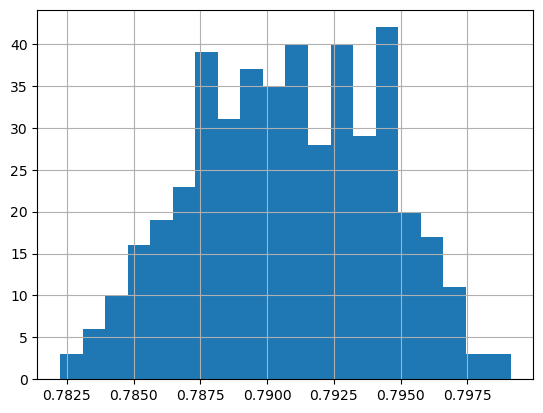

In [277]:
plt.hist(freqs_mode_1, 20)
plt.grid()
plt.show()